Populating the interactive namespace from numpy and matplotlib


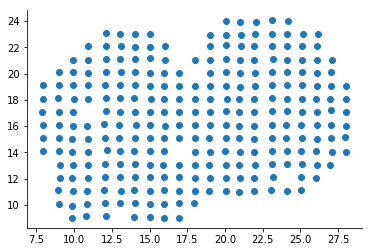

In [2]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

results = pd.read_csv('../MouseOB/MOB_final_results.csv', index_col=0)
ms_results = pd.read_csv('../MouseOB/MOB_MS_results.csv', index_col=0)
sample_info = pd.read_csv('../MouseOB/MOB_sample_info.csv', index_col=0)

df = pd.read_csv('../MouseOB/data/Rep11_MOB_0.csv', index_col=0)
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes
sample_info = sample_info.query('total_counts > 10')  # Remove empty features
df = df.loc[sample_info.index]
dfm = np.log10(df + 1)

plt.scatter(sample_info.x, sample_info.y);

In [3]:
X = sample_info[['x', 'y']]

In [4]:
import SpatialDE

In [5]:
SpatialDE.base.get_l_limits(X)

(0.40200124377918117, 42.954931777387323)

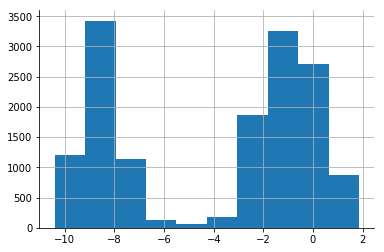

In [6]:
results.max_s2_t_hat.pipe(np.log10).hist()

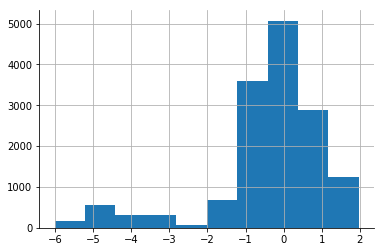

In [7]:
(results.max_s2_t_hat * results.max_delta).pipe(np.log10).hist()

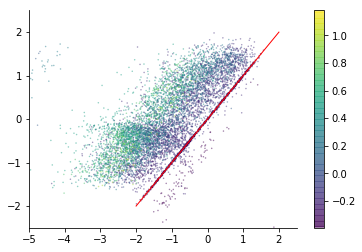

In [8]:
plt.scatter(results.max_s2_t_hat.pipe(np.log10),
            (results.max_s2_t_hat * results.max_delta).pipe(np.log10),
            marker='.',
            c=results.l.pipe(np.log10),
            s=1,
            alpha=0.5)

plt.colorbar()

plt.xlim(-5, 2.5)
plt.ylim(-2.5, 2.5);

plt.plot([-2, 2], [-2, 2], c='r', lw=1);

In [9]:
from scipy import stats

In [10]:
mu = np.array([-0.5, 0.0])
sigma = np.array([[1.0, 0.75],
                  [0.75, 1.0]]);

s = stats.multivariate_normal.rvs(mu, 0.5 * sigma, size=100)

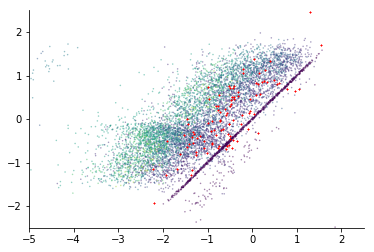

In [11]:
plt.scatter(results.max_s2_t_hat.pipe(np.log10),
            (results.max_s2_t_hat * results.max_delta).pipe(np.log10),
            marker='.',
            c=results.l.pipe(np.log10),
            s=1,
            alpha=0.5)

plt.scatter(s[:, 0], s[:, 1], c='r', s=1, marker='x')

plt.xlim(-5, 2.5)
plt.ylim(-2.5, 2.5);

In [12]:
l_min, l_max = SpatialDE.base.get_l_limits(X)
l_min, l_max = l_min / 2, l_max * 2

In [36]:
sim_expr = pd.DataFrame(index=range(X.shape[0]))
ground_truth = pd.DataFrame(index=['delta', 'FSV', 'l'])
j = 0

FSVs = 10 ** np.random.uniform(-2, 0, 200)
for l in np.logspace(np.log10(l_min), np.log10(l_max), 15):
    print(l)
    K = SpatialDE.base.SE_kernel(X, l)
    I = np.eye(K.shape[0])
    O = np.zeros(K.shape[0])
    for fsv in FSVs:
        delta = 1. / fsv - 1.
        KI = K + delta * I
        
        gex = stats.multivariate_normal.rvs(O, KI)
        
        sim_expr[j] = gex
        ground_truth[j] = [delta, fsv, l]
        
        j += 1
        
ground_truth = ground_truth.T

0.20100062189
0.30982392107
0.477565000369
0.736122403946
1.13466479573
1.74898113651
2.69589311962
4.15547061125
6.40527470295
9.87314021887
15.2185350827
23.4579682786
36.1582946564
55.7346764619
85.9098635548


In [37]:
results = SpatialDE.run(X, sim_expr)
results.loc[results.pval < 1e-16, 'pval'] = 1e-16

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 0.11s
INFO:root:Fitting gene models
INFO:root:Model 1 of 10
INFO:root:Model 2 of 10                             
INFO:root:Model 3 of 10                             
INFO:root:Model 4 of 10                             
INFO:root:Model 5 of 10                             
INFO:root:Model 6 of 10                             
INFO:root:Model 7 of 10                             
INFO:root:Model 8 of 10                             
INFO:root:Model 9 of 10                             
INFO:root:Model 10 of 10                            


In [38]:
results = results.sort_values('g')

In [39]:
results.head().T

,2175,0,1092,1,2
FSV,0.084474,2.0597e-09,0.149238,2.0597e-09,2.0597e-09
M,4,4,4,4,4
g,0,1,2,3,4
l,3.2056,0.402001,0.675535,0.402001,0.402001
max_delta,9.01639,4.85165e+08,5.6637,4.85165e+08,4.85165e+08
max_ll,-889.893,-615.587,-649.078,-715.312,-851.206
max_mu_hat,0.528532,-0.15167,0.0228412,0.121903,1.31929
max_s2_t_hat,5.75328,1.37924e-08,1.3013,2.9631e-08,8.77816e-08
model,SE,SE,SE,SE,SE
n,260,260,260,260,260


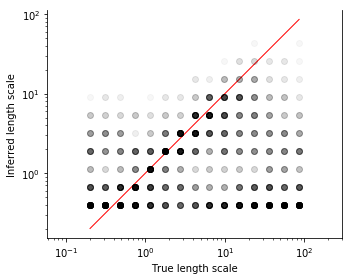

In [40]:
figsize(5, 4)
plt.loglog()
plt.plot([l_min, l_max], [l_min, l_max], c='r', lw=1, zorder=-1)
plt.scatter(ground_truth.l, results.l, alpha=0.03, c='k');
plt.axis('equal');
plt.xlabel('True length scale')
plt.ylabel('Inferred length scale');

plt.tight_layout()
plt.savefig('model_simulation_lengthscales.pdf', bbox_inches='tight')

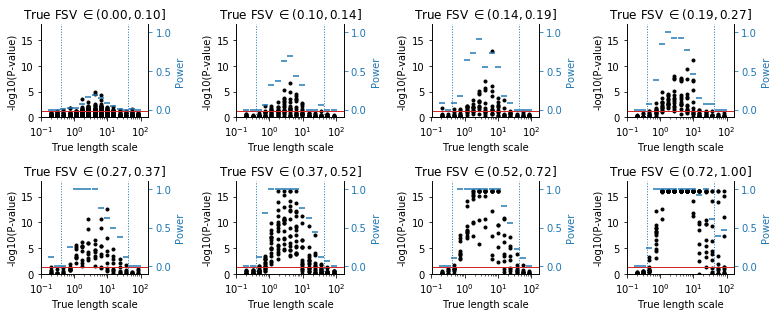

In [41]:
figsize(11, 4.5)
rcParams['axes.spines.right'] = True

N = 8
irvl = np.logspace(-1, 0, N)
irvl = np.insert(irvl, 0, 0.)
for i in range(N):
    i0, i1 = irvl[i], irvl[i+1]
    gt_part = ground_truth.query('@i0 < FSV <= @i1')
    res_part= results.query('g in @gt_part.index')
    
    plt.subplot(2, N // 2, i + 1)
    
    plt.xscale('log')
    plt.scatter(gt_part.l,
                -np.log10(res_part.pval),
                c='k',
                marker='.');

    plt.axhline(-np.log10(0.05), lw=1, c='tab:red');
    plt.axvline(l_min * 2, c='tab:blue', lw=1, ls=':')
    plt.axvline(l_max / 2, c='tab:blue', lw=1, ls=':')
    
    plt.ylim(0, 18)
    plt.xlim(l_min / 2, l_max * 2)
    
    plt.title('True FSV $\in ({:.2f}, {:.2f}]$'.format(i0, i1))
    plt.xlabel('True length scale')
    plt.ylabel('-log10(P-value)')
    
    ax2 = plt.gca().twinx()
    
    comb_part = res_part[['g', 'pval']].join(gt_part, on='g')
    comb_part['significant'] = comb_part.pval < 0.05
    sig_per_l = comb_part.groupby('l').sum()['significant']
    tot_per_l = comb_part.groupby('l').count()['significant']
    power_part = sig_per_l / tot_per_l
    plt.scatter(power_part.index, power_part, marker='_', color='tab:blue')
    plt.ylim(-0.1, 1.1)

    plt.ylabel('Power', color='tab:blue')
    ax2.tick_params('y', colors='tab:blue')
    
plt.tight_layout()
plt.savefig('model_simulation.pdf', bbox_inches='tight')